In [65]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
sns.set_context("talk")


def get_hits_summary(hits_path, label = "label_placeholder", drop = None):
    # Check how many structures I retrieve
    colnames = ["query", "target", "fident", "alnlen", "mismatch", "qseq", "tseq", "qend", "tstart", "tend", "evalue", "bits", "qcov", "tcov", "family"]
    hits_summary = pd.DataFrame()
    for file in glob.glob(hits_path):
        family = os.path.splitext(os.path.basename(file))[0]

        if os.path.getsize(file) > 0: 
            df = pd.read_csv(file, sep= "\t", header = None)
            if drop: 
                df.drop(df.columns[14:19], axis=1, inplace=True)
            df["family"] = family.replace("_filtered_hits", "")
            hits_summary = pd.concat([hits_summary, df])
    hits_summary = hits_summary.set_axis(colnames, axis='columns')
    hits_summary = hits_summary[["family", "query"]].drop_duplicates().groupby("family").count().reset_index().set_axis(["family", "found"], axis='columns')
    hits_summary["label"] = label
    return(hits_summary)

# Collect dataset infos

In [66]:
outdir = "../outdir"
families = pd.read_csv(os.path.join(outdir, "REFERENCES/SUMMARIES/input_sequences/stats_summary_report.csv"))
families.rename(columns = {"id":"family"}, inplace=True)
families.family = families.family.str.replace('.', "-", regex = False)

In [125]:

hits_9 = get_hits_summary(os.path.join(outdir, "REFERENCES/SEARCH/filter/0.9_1/*.m8"), label = "0.9")
hits_9_summary = hits_9.merge(families, on = "family", how = "outer").fillna(0)

hits_1 = get_hits_summary(os.path.join(outdir, "REFERENCES/SEARCH/filter/1_1/*.m8"),   label = "1")
hits_1_summary = hits_1.merge(families, on = "family", how = "outer").fillna(0)

# References 

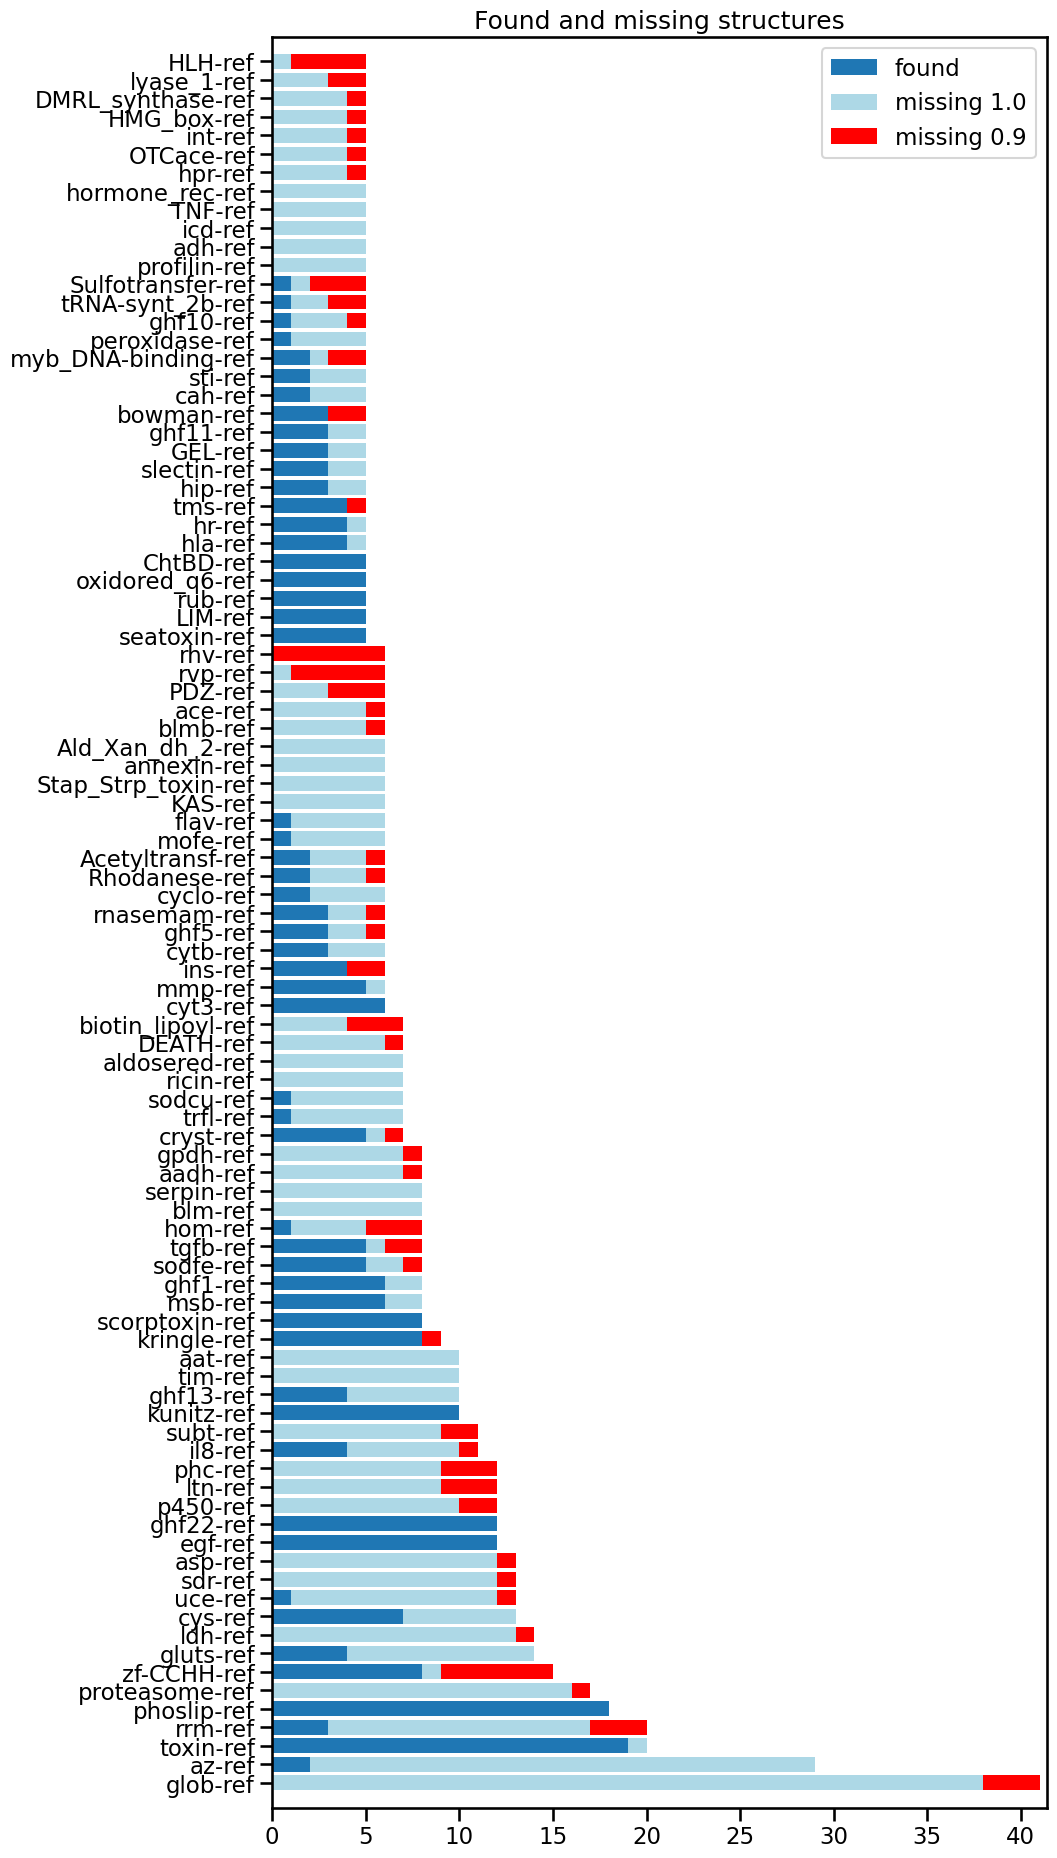

In [131]:
hits_all = hits_1.merge(hits_9, on = "family", how = "outer", suffixes= ("_1", "_0.9")).drop(columns = ["label_1", "label_0.9"]).fillna(0)
hits = families.merge(hits_all, on = "family", how = "left").fillna(0)
hits["missing_0.9"] = hits.n_sequences - hits["found_0.9"]
hits["missing_1.0"] = hits.n_sequences - hits.found_1
hits = hits.sort_values(by=['n_sequences', "found_1", "found_0.9"], ascending=False)

plt.figure(figsize=(10, 23))
plt.barh(hits.family, hits.found_1, label = "found")
plt.barh(hits.family, hits["missing_1.0"], left= hits.found_1, label = "missing 1.0", color = "lightblue")
plt.barh(hits.family, hits["missing_0.9"], left= hits.n_sequences - hits["missing_0.9"] , label = "missing 0.9", color = "red")
plt.title("Found and missing structures")
plt.legend(loc = "upper right")
plt.margins(0.01)
plt.show()


# Complete dataset 

In [50]:
full_filtered_hits_9 = "/home/luisasantus/Desktop/crg_cluster/projects/nf-core-getstructures/outdir/full/filter/0.9_1/*.m8"
full_hits_9_summary = get_hits_summary(full_filtered_hits_9, drop = True)
full_hits_9 = full_hits_9_summary[["family", "query"]].drop_duplicates().groupby("family").count().reset_index().set_axis(["family", "found_9"], axis='columns')
families.family = families.family.str.replace("-ref", "")

In [55]:
#hits = families.merge(full_hits_9, on = "family", how = "left").fillna(0)
hits = families.merge(full_hits_9, on = "family", how = "right").fillna(0)
hits["missing_0.9"] = hits.n_sequences_combined - hits.found_9

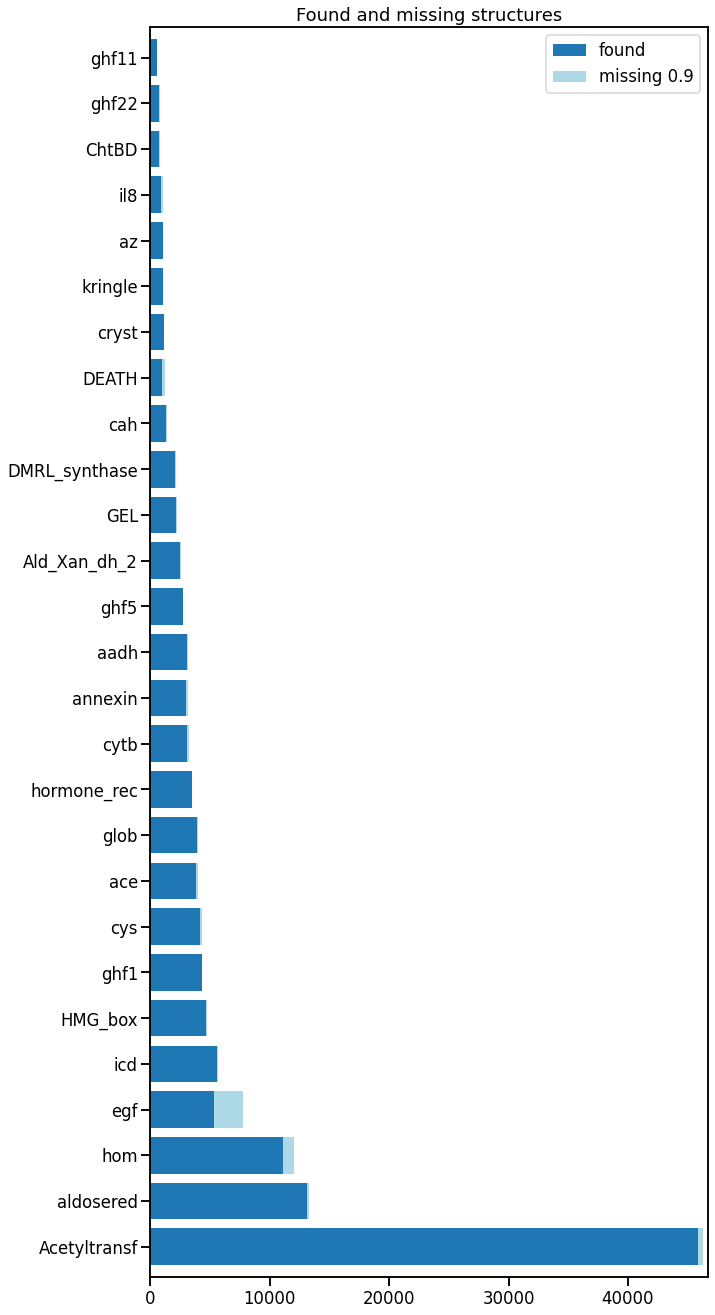

In [56]:
hits = hits.sort_values(by=['n_sequences_combined', "found_9"], ascending=False)
plt.figure(figsize=(10, 23))
plt.barh(hits.family, hits.found_9, label = "found")
plt.barh(hits.family, hits["missing_0.9"], left= hits.found_9, label = "missing 0.9", color = "lightblue")
plt.title("Found and missing structures")
plt.legend(loc = "upper right")
plt.margins(0.01)
plt.show()

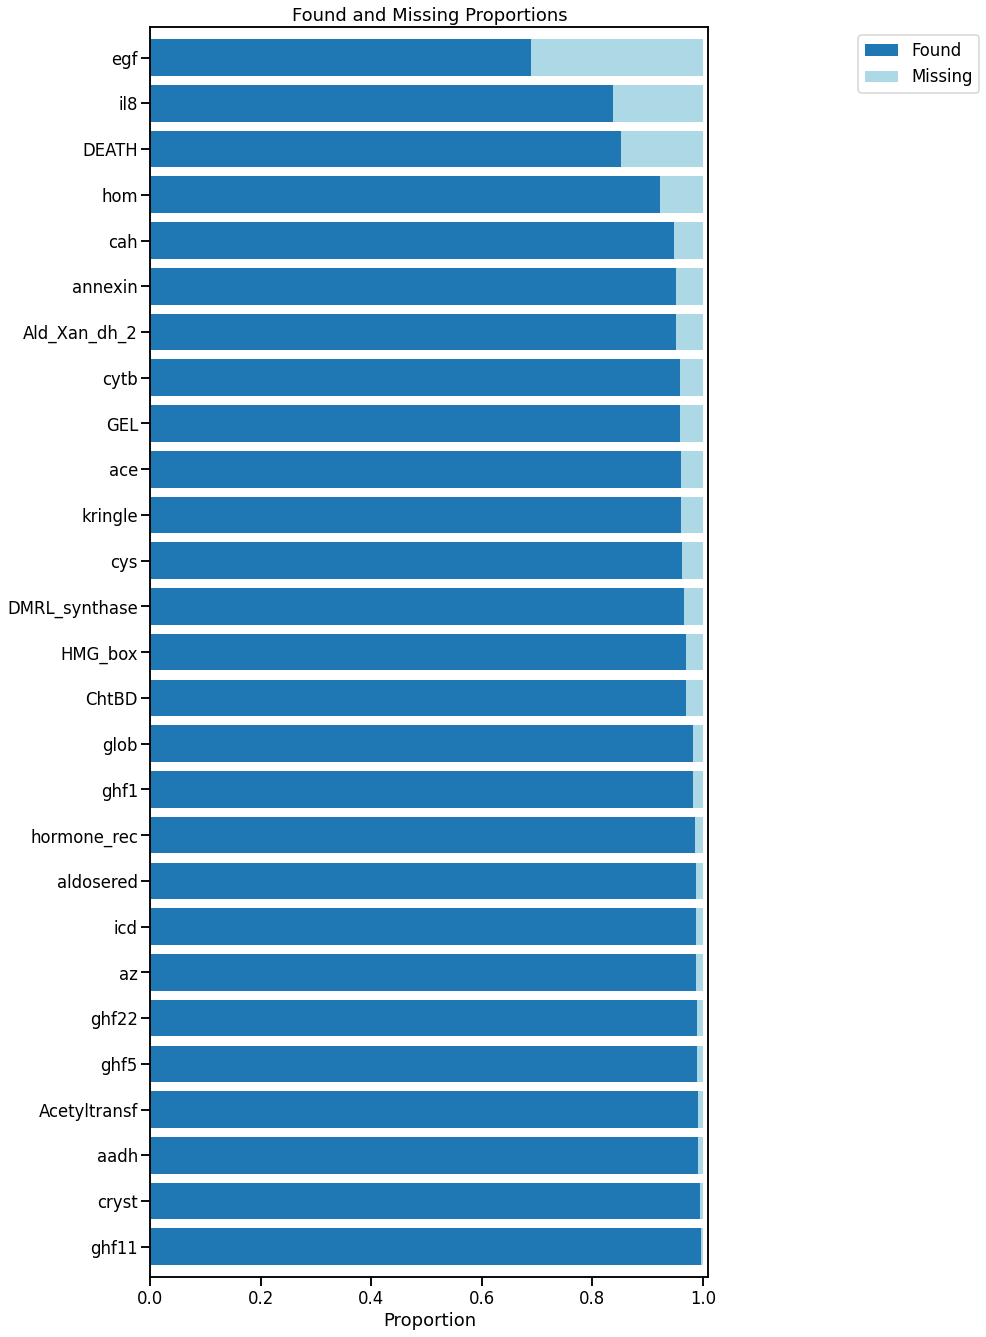

In [67]:
# Plot with proportions
# Calculate proportions
hits['found_proportion'] = hits['found_9'] / (hits['found_9'] + hits['missing_0.9'])
hits['missing_proportion'] = hits['missing_0.9'] / (hits['found_9'] + hits['missing_0.9'])

# Sort by the found_proportion in descending order
hits = hits.sort_values(by=['found_proportion'], ascending=False)

plt.figure(figsize=(10, 23))

# Plot found proportions
plt.barh(hits.family, hits['found_proportion'], label="Found")

# Plot missing proportions next to found proportions
plt.barh(hits.family, hits['missing_proportion'], left=hits['found_proportion'], label="Missing", color="lightblue")

plt.title("Found and Missing Proportions" ) 
plt.xlabel("Proportion")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.margins(0.01)
plt.show()